In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

import importlib
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools
import math_functions as mf

from scipy.optimize import root
from scipy.integrate import odeint

fig_folder = "C:/Users/Orlando/ownCloud - ORLANDO Marcelo@mycore.cnrs.fr/Doutorado/Skeleton model/Figures_v1/"
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder) 

In [4]:
import skeleton_model_v1_functions 


In [139]:
PQ_tot_test = 1.5
PC_tot_test = 3

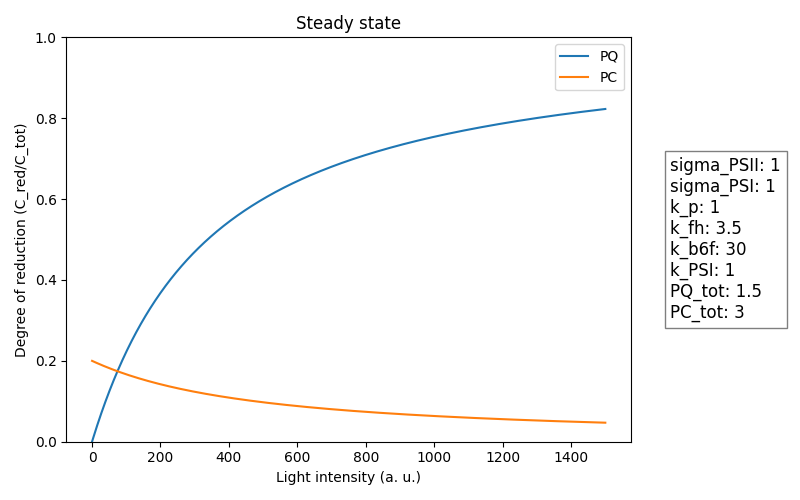

In [140]:
####### steady state light curve ########

importlib.reload(skeleton_model_v1_functions)
from skeleton_model_v1_functions import light_curve

# define model parameters

sigma_PSII = 1
sigma_PSI = 1
k_p = 1
k_fh = 3.5
k_b6f = 30
k_PSI = 1
PQ_tot = PQ_tot_test
PC_tot = PC_tot_test

parameter_keys = ['sigma_PSII', 'sigma_PSI', 'k_p', 'k_fh', 'k_b6f', 'k_PSI', 'PQ_tot', 'PC_tot']
parameters = dict(zip(parameter_keys, [sigma_PSII, sigma_PSI, k_p, k_fh, k_b6f, k_PSI, PQ_tot, PC_tot]))

### define light curve parameters ###

min_light = 0.1
max_light = 1500
light_steps = 1000


### run the model ###
light_range, X_PQ_red_steady, X_PC_red_steady = light_curve(min_light, max_light, light_steps, parameters)

### plot the results ###
    
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title('Steady state')
ax.plot(light_range, X_PQ_red_steady, label='PQ')
ax.plot(light_range, X_PC_red_steady, label='PC')
ax.set_ylabel('Degree of reduction (C_red/C_tot)')
ax.set_xlabel('Light intensity (a. u.)')
ax.legend()

ax.set_ylim(0, 1)

# Create a string with parameter names and values
parameters_str = '\n'.join([f'{key}: {value}' for key, value in parameters.items()])

# Add the text box to the right of the plot but within the figure
ax.text(1.07, 0.5, parameters_str, fontsize=12, verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))

fig.tight_layout()


In [141]:
####### Bode plot of the dynamic response to a sinusoidal light intensity #######

importlib.reload(skeleton_model_v1_functions)
from skeleton_model_v1_functions import simulate_bode_plot

# define the acquisition parameters

freq_min = 0.01
freq_max = 1000
nb_freqs = 50

nb_periods = 20
points_per_period = 100
period_start_fft = 10

# define the light intensity

offset = 100
amplitude = 10

# define model parameters

sigma_PSII = 1
sigma_PSI = 1
k_p = 1
k_fh = 3.5
k_b6f = 30
k_PSI = 1
PQ_tot = PQ_tot_test
PC_tot = PC_tot_test

parameter_keys = ['sigma_PSII', 'sigma_PSI', 'k_p', 'k_fh', 'k_b6f', 'k_PSI', 'PQ_tot', 'PC_tot']
parameters = dict(zip(parameter_keys, [sigma_PSII, sigma_PSI, k_p, k_fh, k_b6f, k_PSI, PQ_tot, PC_tot]))

# run the model

harmonics_PQ, harmonics_PC, frequencies, times, X_PQ_red, X_PC_red = simulate_bode_plot(freq_min, freq_max, nb_freqs, nb_periods, points_per_period, period_start_fft, offset, amplitude, parameters)



In [142]:
coupled = {'f': frequencies, 'A_PQ': harmonics_PQ["A_0"], 'A_PC': harmonics_PC["A_0"], 'P_PQ': harmonics_PQ["P_0"] + 90, 'P_PC': harmonics_PC["P_0"]+ 90 - 360}
my_params = parameters_str

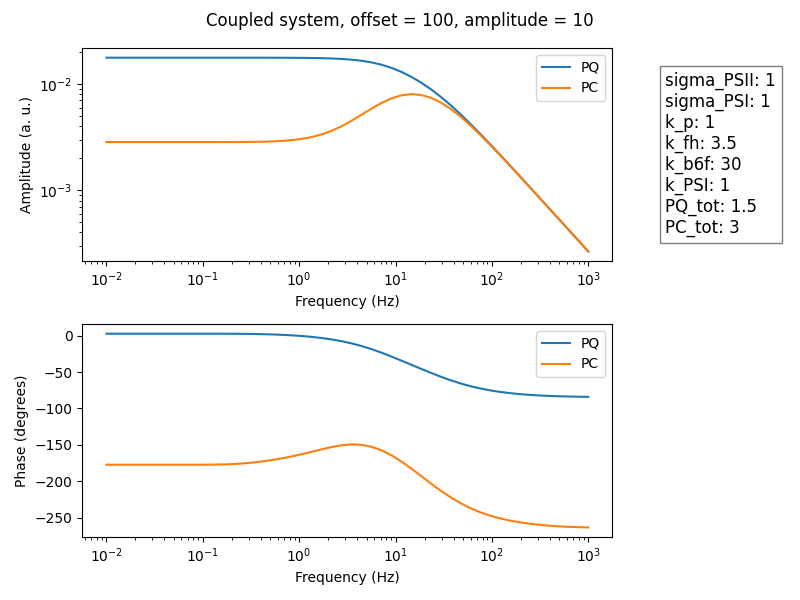

In [143]:
# Plot the results

fig, ax = plt.subplots(2, 1, figsize=(8, 6))
fig.suptitle(f"Coupled system, offset = {offset}, amplitude = {amplitude}")
ax[0].loglog(frequencies, harmonics_PQ['A_0'], label='PQ')
ax[0].loglog(frequencies, harmonics_PC['A_0'], label='PC')
ax[0].set_ylabel('Amplitude (a. u.)')
ax[0].set_xlabel('Frequency (Hz)')
ax[0].legend()
ax[1].semilogx(frequencies, harmonics_PQ['P_0'] + 90 , label='PQ')
ax[1].semilogx(frequencies, harmonics_PC['P_0'] + 90 - 360, label='PC')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Phase (degrees)')
ax[1].legend()

# Create a string with parameter names and values
parameters_str = '\n'.join([f'{key}: {value}' for key, value in parameters.items()])
ax[0].text(1.1, 0.5, parameters_str, fontsize=12, verticalalignment='center', transform=ax[0].transAxes, bbox=dict(facecolor='white', alpha=0.5))

fig.tight_layout()

fig.savefig(fig_folder + "/test_coupling/" +  f"bode_plot_coupled_{offset}_{amplitude}_{PQ_tot}_{PC_tot}.png", dpi=300)


In [144]:
########## Functions to define the uncoupled model ##########

def model_uncoupled(y, t, I, parameters):
    # Unpack state variables (degree of reduction)
    X_PQ_red = y[0]
    X_PC_red = y[1]
    
    # Unpack parameters
    sigma_PSII = parameters["sigma_PSII"]
    sigma_PSI = parameters["sigma_PSI"]
    k_p = parameters["k_p"]
    k_fh = parameters["k_fh"]
    k_b6f = parameters["k_b6f"]
    k_PSI = parameters["k_PSI"]
    PQ_tot = parameters["PQ_tot"]
    PC_tot = parameters["PC_tot"]
    X_PQ_red_uncoupled = parameters.get("X_PQ_red_uncoupled", 0.5)
    X_PC_red_uncoupled = parameters.get("X_PC_red_uncoupled", 0.5)
    
    # Calculate concentrations from degrees of reduction
    C_PQ = PQ_tot * (1 - X_PQ_red)
    C_PQH2 = PQ_tot * X_PQ_red
    C_PC_plus = PC_tot * (1 - X_PC_red)
    C_PC = PC_tot * X_PC_red
    
    C_PQH2_uncoupled = PQ_tot * X_PQ_red_uncoupled
    C_PC_plus_uncoupled = PC_tot * (1 - X_PC_red_uncoupled)
    
    # Calculate fluxes using concentrations
    J_PSII = (I * sigma_PSII * k_p * C_PQ) / (k_p * C_PQ + k_fh)
    J_b6f = k_b6f * C_PC_plus * C_PQH2
    J_PSI = k_PSI * I * sigma_PSI * C_PC
    
    # Calculate derivatives of the degree of reduction
    dX_PQ_red_dt = (J_PSII - k_b6f * C_PC_plus_uncoupled * C_PQH2) / PQ_tot
    dX_PC_red_dt = (2 * k_b6f * C_PC_plus * C_PQH2_uncoupled - J_PSI) / PC_tot
    
    return [dX_PQ_red_dt, dX_PC_red_dt]

########## Function to obtain the steady state light curve ##########

def light_curve_uncoupled(min_light, max_light, light_steps, parameters):
    light_range = np.linspace(min_light, max_light, light_steps)[::-1]

    X_PQ_red_steady = np.zeros(light_steps)
    X_PC_red_steady = np.zeros(light_steps)

    ### initial guess for the max light ###
    X_PQ_red_guess = 1
    X_PC_red_guess = 0

    for i, light in enumerate(light_range):
        if i == 0:
            y0 = [X_PQ_red_guess, X_PC_red_guess]
        else:
            y0 = [X_PQ_red_steady[i-1], X_PC_red_steady[i-1]]

        sol = root(model_uncoupled, y0, args=(0, light, parameters))
        X_PQ_red_steady[i] = sol.x[0]
        X_PC_red_steady[i] = sol.x[1]

    return light_range, X_PQ_red_steady, X_PC_red_steady

########## Function to obtain the dynamic response to a step change in light ##########

def response_step_uncoupled(light_1, light_2, time_light, t_start, t_end, n_points, parameters):
    time = np.linspace(t_start, t_end, n_points)
    light = np.zeros(n_points)
    light[time < time_light] = light_1
    light[time >= time_light] = light_2

    X_PQ_red = np.zeros(n_points)
    X_PC_red = np.zeros(n_points)
    
    ### compute the initial conditions from steady state at light 1 ###
    steady_state_sol = root(model_uncoupled, [0.5, 0.5], args=(0, light_1, parameters))

    X_PQ_red[0] = steady_state_sol.x[0]
    X_PC_red[0] = steady_state_sol.x[1]
    
    ### integrate the model one time step at a time ###

    for i in range(1, n_points):
        time_interval = [time[i-1], time[i]]
        y = odeint(model_uncoupled, [X_PQ_red[i-1], X_PC_red[i-1]], time_interval, args=(light[i], parameters))
        X_PQ_red[i] = y[-1, 0]
        X_PC_red[i] = y[-1, 1]
        
    return time, light, X_PQ_red, X_PC_red


########## Function to obtain the dynamic response to a sinusoidal light ##########

def response_sinusoid_uncoupled(freq, nb_periods, points_per_period, offset, amplitude, parameters):
    time = np.linspace(0, nb_periods/freq, nb_periods * points_per_period)
    light = offset + amplitude * np.sin(2 * np.pi * freq * time)

    X_PQ_red = np.zeros(nb_periods * points_per_period)
    X_PC_red = np.zeros(nb_periods * points_per_period)
    
    ### compute the initial conditions from steady state at light 1 ###
    steady_state_sol = root(model_uncoupled, [0.5, 0.5], args=(0, offset, parameters))

    X_PQ_red[0] = steady_state_sol.x[0]
    X_PC_red[0] = steady_state_sol.x[1]
    
    ### integrate the model one time step at a time ###

    for i in range(1, nb_periods * points_per_period):
        time_interval = [time[i-1], time[i]]
        y = odeint(model_uncoupled, [X_PQ_red[i-1], X_PC_red[i-1]], time_interval, args=(light[i], parameters))
        X_PQ_red[i] = y[-1, 0]
        X_PC_red[i] = y[-1, 1]
        
    return time, light, X_PQ_red, X_PC_red


########## Functions to obtain the bode plot ##########

def get_harmonics(input_freq, F, A, P, pic_search_window):
    index_fund = tools.closest_index(F, input_freq)
    harmonics = {'f_input': input_freq}
    for i in range(5):
        index = index_fund*(i+1)
        search_window = [index - pic_search_window, index + pic_search_window]
        index_max = np.argmax(A[search_window[0]:search_window[1]]) + search_window[0]
        harmonics[f'A_{i}'] = A[index_max]
        harmonics[f'f_{i}'] = F[index_max]
        harmonics[f'P_{i}'] = P[index_max]

    return pd.DataFrame(harmonics, index=[0])

def simulate_bode_plot_uncoupled(freq_min, freq_max, nb_freqs, nb_periods, points_per_period, period_start_fft, offset, amplitude, parameters):
    
    # Create a dictionary to store the results
    X_PQ_red = np.zeros((nb_freqs, nb_periods * points_per_period))
    X_PC_red = np.zeros((nb_freqs, nb_periods * points_per_period))
    times = np.zeros((nb_freqs, nb_periods * points_per_period))

    # Run the dynamic response for each frequency
    frequencies = np.logspace(np.log10(freq_min), np.log10(freq_max), nb_freqs)

    harmonics_PQ = pd.DataFrame()
    harmonics_PC = pd.DataFrame()

    for i in range(nb_freqs):
        freq = frequencies[i]
        times[i], _, X_PQ_red[i], X_PC_red[i] = response_sinusoid_uncoupled(freq, nb_periods, points_per_period, offset, amplitude, parameters)
        F, A, P = tools.FFT(times[i][int(points_per_period*period_start_fft):], X_PQ_red[i][int(points_per_period*period_start_fft):])
        harmonics_PQ = pd.concat([harmonics_PQ, get_harmonics(freq, F, A, P, 5)])
        
        F, A, P = tools.FFT(times[i][int(points_per_period*period_start_fft):], X_PC_red[i][int(points_per_period*period_start_fft):])
        harmonics_PC = pd.concat([harmonics_PC, get_harmonics(freq, F, A, P, 5)])

    return harmonics_PQ, harmonics_PC, frequencies, times, X_PQ_red, X_PC_red 


In [145]:
####### get the steady state values for the offset light intensity #######
light_index = tools.closest_index(light_range, offset)
X_PQ_red_uncoupled = X_PQ_red_steady[light_index]
X_PC_red_uncoupled = X_PC_red_steady[light_index]

In [146]:
# define model parameters

sigma_PSII = 1
sigma_PSI = 1
k_p = 1
k_fh = 3.5
k_b6f = 30
k_PSI = 1
PQ_tot = PQ_tot_test
PC_tot = PC_tot_test

####### get the steady state values for the offset light intensity #######
light_index = tools.closest_index(light_range, offset)
X_PQ_red_uncoupled = X_PQ_red_steady[light_index]
X_PC_red_uncoupled = X_PC_red_steady[light_index]


parameter_keys = ['sigma_PSII', 'sigma_PSI', 'k_p', 'k_fh', 'k_b6f', 'k_PSI', 'PQ_tot', 'PC_tot', 'X_PQ_red_uncoupled', 'X_PC_red_uncoupled']
parameters = dict(zip(parameter_keys, [sigma_PSII, sigma_PSI, k_p, k_fh, k_b6f, k_PSI, PQ_tot, PC_tot, X_PQ_red_uncoupled, X_PC_red_uncoupled]))

# run the model

harmonics_PQ, harmonics_PC, frequencies, times, X_PQ_red, X_PC_red = simulate_bode_plot_uncoupled(freq_min, freq_max, nb_freqs, nb_periods, points_per_period, period_start_fft, offset, amplitude, parameters)

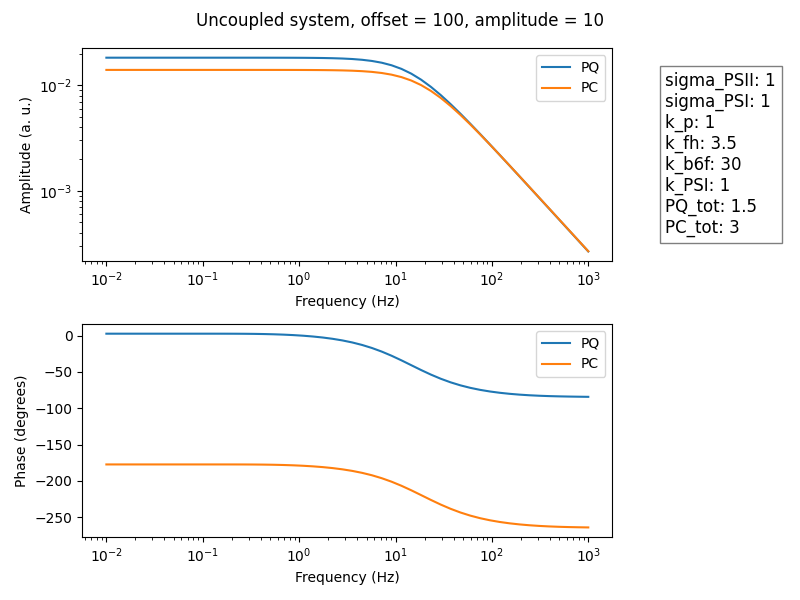

In [147]:
# Plot the results

fig, ax = plt.subplots(2, 1, figsize=(8, 6))
fig.suptitle(f"Uncoupled system, offset = {offset}, amplitude = {amplitude}")
ax[0].loglog(frequencies, harmonics_PQ['A_0'], label='PQ')
ax[0].loglog(frequencies, harmonics_PC['A_0'], label='PC')
ax[0].set_ylabel('Amplitude (a. u.)')
ax[0].set_xlabel('Frequency (Hz)')
ax[0].legend()
ax[1].semilogx(frequencies, harmonics_PQ['P_0'] + 90 , label='PQ')
ax[1].semilogx(frequencies, harmonics_PC['P_0'] + 90 - 360, label='PC')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Phase (degrees)')
ax[1].legend()

# Create a string with parameter names and values
ax[0].text(1.1, 0.5, my_params, fontsize=12, verticalalignment='center', transform=ax[0].transAxes, bbox=dict(facecolor='white', alpha=0.5))

fig.tight_layout()

fig.savefig(fig_folder + "/test_coupling/" +  f"bode_plot_uncoupled_{offset}_{amplitude}_{PQ_tot}_{PC_tot}.png", dpi=300)

In [148]:
uncoupled = {'f': frequencies, 'A_PQ': harmonics_PQ["A_0"], 'A_PC': harmonics_PC["A_0"], 'P_PQ': harmonics_PQ["P_0"] + 90, 'P_PC': harmonics_PC["P_0"]+ 90 - 360}

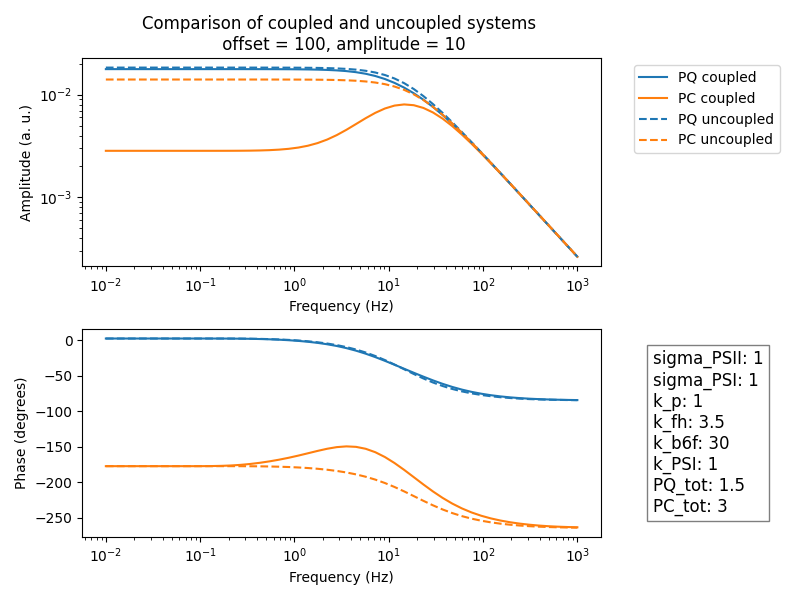

In [149]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].set_title(f"Comparison of coupled and uncoupled systems \n offset = {offset}, amplitude = {amplitude}")
ax[0].loglog(coupled['f'], coupled['A_PQ'], '-', color = 'C0', label='PQ coupled')
ax[0].loglog(coupled['f'], coupled['A_PC'], '-', color = 'C1', label='PC coupled')
ax[0].loglog(uncoupled['f'], uncoupled['A_PQ'], '--', color = 'C0', label='PQ uncoupled')
ax[0].loglog(uncoupled['f'], uncoupled['A_PC'], '--', color = 'C1', label='PC uncoupled')
ax[0].set_ylabel('Amplitude (a. u.)')
ax[0].set_xlabel('Frequency (Hz)')
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1].semilogx(coupled['f'], coupled['P_PQ'], '-', color = 'C0', label='PQ coupled')
ax[1].semilogx(coupled['f'], coupled['P_PC'], '-', color = 'C1', label='PC coupled')
ax[1].semilogx(uncoupled['f'], uncoupled['P_PQ'], '--', color = 'C0', label='PQ uncoupled')
ax[1].semilogx(uncoupled['f'], uncoupled['P_PC'], '--', color = 'C1', label='PC uncoupled')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Phase (degrees)')
ax[1].text(1.1, 0.5, my_params, fontsize=12, verticalalignment='center', transform=ax[1].transAxes, bbox=dict(facecolor='white', alpha=0.5))

fig.tight_layout()
fig.savefig(fig_folder + "/test_coupling/" +  f"bode_plot_comparison_{offset}_{amplitude}_{PQ_tot}_{PC_tot}.png", dpi=300)